# Основные виды нейросетей (CNN и RNN)

**Разработчик: Алексей Умнов**

## Сверточные сети

Вернемся в очередной раз к датасету MNIST. Для начала загрузим данные и определим несколько полезных функций как на прошлом семинаре.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

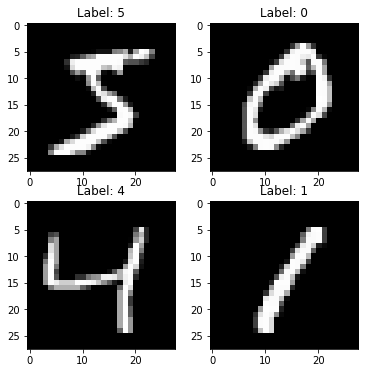

In [2]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [3]:
from util import iterate_minibatches

def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print("Epoch {} error = {:.2%}".format(epoch, 1 - val_acc_log[-1][1]))
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

**Задание 1:** Реализуйте сверточную сеть, которая состоит из двух последовательных применений свертки, relu и max-пулинга, а потом полносвязного слоя. Подберите параметры так, чтобы на выходе последнего слоя размерность тензора была 4 x 4 x 16. В коде ниже используется обертка nn.Sequential.

Добейтесь, чтобы ошибка классификации после обучения (см. ниже) была не выше 1.5%.

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Linear(4 * 4 * 16, 10)
        
    def forward(self, x):
        
        x = x.view(-1, 1, 28, 28)
        x = self.features(x)
        x = x.view(-1, 16 * 4 * 4)
        out = self.classifier(x)
        
        # <your code here>
        return F.log_softmax(out, dim=-1)

Посчитаем количество обучаемых параметров сети (полносвязные сети с прошлых семинаров имеют 30-40 тысяч параметров).

In [5]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

model = ConvNet()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 9402


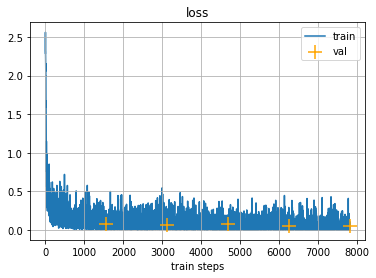

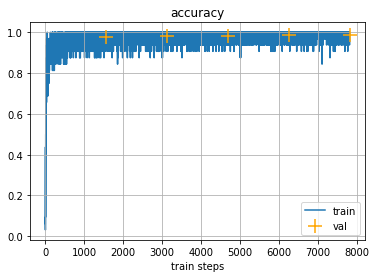

Epoch 4 error = 1.52%
Final error: 1.52%
CPU times: user 2min 59s, sys: 1.9 s, total: 3min 1s
Wall time: 47 s


In [6]:
%%time

opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 5)

Мы с легкостью получили качество классификаци лучше, чем было раньше с помощью полносвязных сетей. На самом деле для более честного сравнения нужно поисследовать обе архитектуры и подождать побольше итераций до сходимости, но в силу ограниченности вычислительных ресурсов мы это сделать не можем. Результаты из которых "выжали максимум" можно посмотреть например, на этой странице: http://yann.lecun.com/exdb/mnist/, и там видно, что качество сверточных сетей гораздо выше. А если работать с более сложными изоражениями (например, с ImageNet), то сверточные сети побеждают с большим отрывом.

**Упражнение:** Ответьте на вопросы ниже:
* Почему сверточные сети обладают таким преимуществом именно для изображений?
* Почему несмотря на малое количество параметров обучение сверточных сетей занимает так много времени?

## Рекуррентные сети

Для рекуррентных сетей используем датасет с именами и будем определять из какого языка произошло данное имя (обратите внимание, здесь задача классификации, а не генерации, как в семинаре). Для этого построим рекуррентную сеть, которая работает с именами на уровне символов. Для начала скачаем файлы и конвертируем их к удобному формату (можно не особо вникать в этот код).

In [16]:
# На Windows придется скачать архив по ссылке (~3Mb) и распаковать самостоятельно
# ! wget -nc https://download.pytorch.org/tutorial/data.zip
# ! unzip -n ./data.zip

In [8]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

['data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/German.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Italian.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/Portuguese.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/Russian.txt']
Slusarski


Определим несколько удобных функций для конвертации букв и слов в тензоры.

**Задание 2**: напишите последнюю функцию для конвертации слова в тензор.

In [9]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i] = letterToTensor(letter)
    return tensor
    # <your code here>

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**Задание 3:** Реализуйте однослойную рекуррентную сеть. Здесь нужно написать самостоятельно реализацию nn.RNNCell, а не пользоваться готовой. 

In [10]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        self.f = nn.Tanh()
        self.hidden_size = hidden_size
#         self.Wx = nn.Parameter(torch.Tensor(hidden_size, input_size))
#         self.Wh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.X = nn.Linear(input_size, hidden_size)
        self.H = nn.Linear(hidden_size, hidden_size)

    def forward(self, input, hidden):
        XX = self.X(input)
        HH = self.H(hidden)
#         XX = torch.mm(input, self.Wx.t())
#         HH = torch.mm(hidden, self.Wh.t())
        hidden = self.f(HH + XX)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnncell = RNNCell(n_letters, n_hidden)

Предсказание будем осуществлять при помощи линейного класссификатора поверх скрытых состояний сети.

In [11]:
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))

Проверим, что все корректно работает: выходы классификаторы должны быть лог-вероятностями.

In [12]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input, hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-3.0432, -2.9187, -2.8762, -2.9443, -2.9644, -2.8173, -2.9596, -2.7816,
         -2.8417, -2.9240, -2.9375, -2.9549, -2.8995, -2.7881, -2.6883, -2.8506,
         -3.0772, -2.8373]], grad_fn=<LogSoftmaxBackward>)
tensor(1.0000, grad_fn=<SumBackward0>)


In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input[0], hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-3.0432, -2.9187, -2.8762, -2.9443, -2.9644, -2.8173, -2.9596, -2.7816,
         -2.8417, -2.9240, -2.9375, -2.9549, -2.8995, -2.7881, -2.6883, -2.8506,
         -3.0772, -2.8373]], grad_fn=<LogSoftmaxBackward>)
tensor(1.0000, grad_fn=<SumBackward0>)


Для простоты в этот раз будем оптимизировать не по мини-батчам, а по отдельным примерам. Ниже несколько полезных функций для этого.

In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Augustin
category = Spanish / line = Guerra
category = Polish / line = Janowski
category = German / line = Welter
category = Russian / line = Bakshtanowski
category = Japanese / line = Ariwara
category = Czech / line = Fritsch
category = Vietnamese / line = Dinh
category = Dutch / line = Altena
category = Russian / line = Granitov


**Задание 4:** Реализуйте вычисление ответа в функции train. Если все сделано правильно, то точность на обучающей выборке должна быть не менее 70%.

100%|██████████| 50000/50000 [02:08<00:00, 389.66it/s]


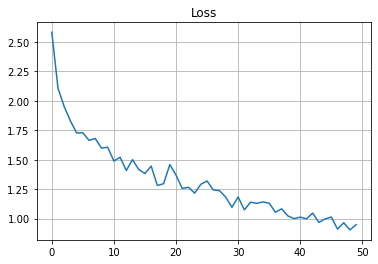

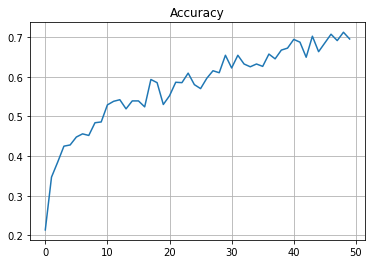

In [15]:
from tqdm import trange

def train(category, category_tensor, line_tensor, optimizer):
    hidden = rnncell.initHidden()

    rnncell.zero_grad()
    classifier.zero_grad()

    for letter in line_tensor:
        hidden = rnncell(letter, hidden)
    output = classifier(hidden)
    
    # <your code here>
    # use rnncell and classifier
    # <end>

    loss = F.nll_loss(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    acc = (categoryFromOutput(output)[0] == category)

    return loss.item(), acc

n_iters = 50000
plot_every = 1000

current_loss = 0
all_losses = []
current_acc = 0
all_accs = []

n_hidden = 128

rnncell = RNNCell(n_letters, n_hidden)
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))
params = list(rnncell.parameters()) + list(classifier.parameters())
opt = torch.optim.RMSprop(params, lr=0.001)
for iter in trange(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    loss, acc = train(category, category_tensor, line_tensor, opt)
    current_loss += loss
    current_acc += acc

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accs.append(current_acc / plot_every)
        current_acc = 0
        
plt.figure()
plt.title("Loss")
plt.plot(all_losses)
plt.grid()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(all_accs)
plt.grid()
plt.show()